# Iris dataset

# Подготовка

Импорт необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Устанавливаем стиль для графиков

In [ ]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Фиксируем генератор случайных чисел для воспроизводимости эксперимента

In [ ]:
np.random.seed(21)
torch.manual_seed(21);

# Чтение данных

Датасет Iris очень популярный "начальный" датасет в среде Машинного Обучения. Поэтому его можно не скачивать отдельно, а сразу взять из библиотеки sklearn.

In [ ]:
iris = load_iris()

Детальное описание датасета и признаков

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Итого:

* Каждый объект (цветок) наших данных имеет **4 признака**
* Мы хотим предсказать какому из **3 классов** (вид цветка) принадлежит объект (цветок)

In [ ]:
n_features = 4    # число признаков
n_classes = 3    # число классов

Создаем таблицу (pandas.DataFrame) с объектами в строках и их признаками в колонках

In [ ]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

Пример данных

In [ ]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
y[:5]

array([0, 0, 0, 0, 0])

Статистики по данным. Их полезно смотреть, чтобы понять какие признаки мы вообще имеем

In [ ]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Все признаки в нашем датасете - непрерывные численные признаки

Также посмотрим имена классов, чтобы мы могли их дальше осознанно трактовать

In [ ]:
class_labels = iris.target_names
class_labels

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Также посмотрим на матрицу корреляций между признаками

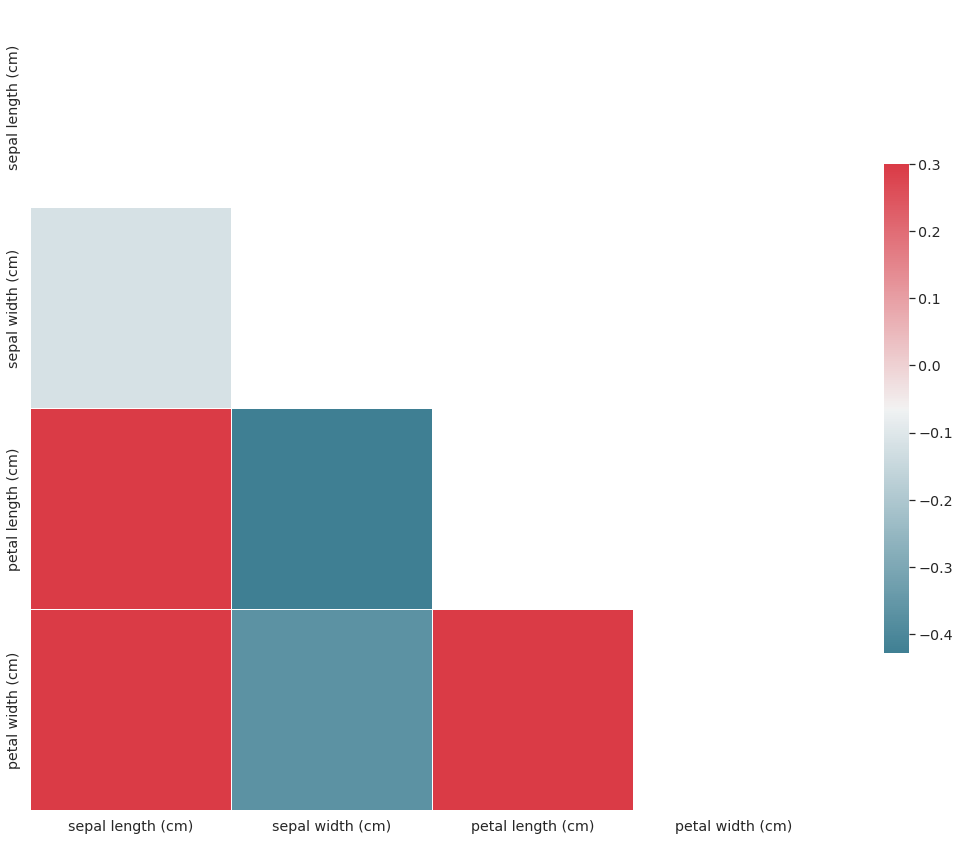

In [ ]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Иногда также имеет смысле посмотреть на попарные распределения признаков. В некоторых случаях из этого анализа становится более понятна природа классов и как правильно строить классификатор.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


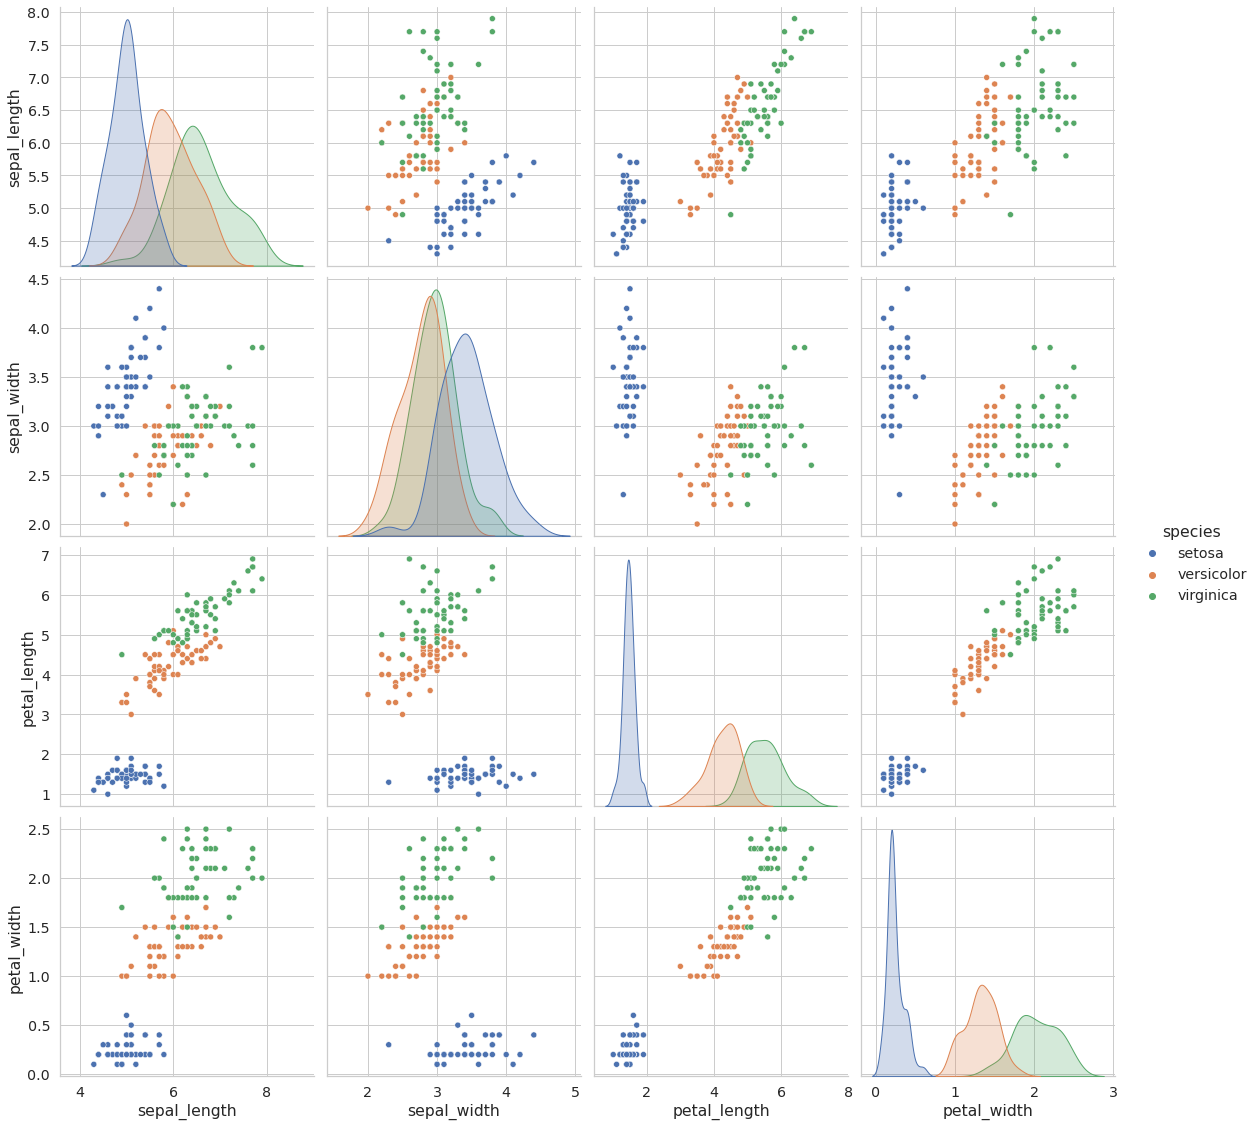

In [ ]:
sns.pairplot(sns.load_dataset("iris"), hue="species", size=4);

Как можно заметить из графика выше, один класс (setosa) отделяется от других очень хорошо. Это значит, что даже линейный простейший классификатор сможет отделить его без ошибок. Два других класса тоже разделены достаточно неплохо, но все же пересекаются. Здесь линейный классификатор тоже должен быть неплох, но нейросеть, предположительно, поможет сделать еще лучше.

Таким образом мы ожидаем очень высокое качество классификации от модели.

# Предобработка данных

## Разбиение

Разобьем наши данные на обучающую и валидационную выборки в пропорции $\frac{4}{1}$

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=21)

## Создаем тензоры

PyTorch требует свой собственный тип векторов, который называется тензор и немного отличается от формата в numpy

In [ ]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float)
X_valid_tensor = torch.tensor(np.array(X_valid), dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

Также определим базовые константы из данных, чтобы использовать их в дальнейшем

In [ ]:
n_data = len(X_train_tensor)

In [ ]:
n_data

120

# Модели

## Бейзлайн: Sklearn Логистическая Регрессия

Чтобы иметь значение качества, от которого дальше можно отталкиваться в сравнении моделей, принято сначала делать самую простую базовую модель. Ее называют бейзлайн (baseline). Здесь в качестве бейзлайна мы возьмем линейную модель классификации из библиотеки Sklearn.

Заметьте, что хоть модель и называется **логистическая регрессия**, она решает задачу **классификации**. Ошибки здесь нет.

In [ ]:
model_lr_sklearn = LogisticRegression(C = 1e8, 
                                      max_iter=5000, 
                                      solver="sag", 
                                      multi_class="multinomial")

Тренируем модель

In [ ]:
model_lr_sklearn.fit(X_train, y_train)

LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

Оцениваем качество

In [ ]:
print("Train accuracy: {:.1f}%".format(model_lr_sklearn.score(X_train, y_train) * 100))
print("Valid accuracy: {:.1f}%".format(model_lr_sklearn.score(X_valid, y_valid) * 100))

Train accuracy: 99.2%
Valid accuracy: 96.7%


Линейный классификатор, как и ожадалось, работает здесь достаточно хорошо.

## PyTorch

В практической части лекции во время обучения модели мы "ходили" по данным вручную с помощью циклов for.

В реальности так делают редко, а чаще всего используют уже существующий утилиты для данных в PyTorch. [Ссылка](https://pytorch.org/docs/stable/data.html). Это позволяет не изобретать колесо заново, а пользоваться стандартными способами для разбиения на батчи, случайной перетасовки данных и многого другого. В случае простых и маленьких данных, которые полностью помещаются в оперативную память это может казаться не таким актуальным. Но в реальности почти всегда приходится работать с большим количеством данных, которые приходится читать с диска по кускам - это сделать самому руками уже не так просто. А еще очень часто модель настолько большая, что обучать ее надо на нескольких компьютерах - и самостоятельная реализация этого заняла бы слишком много времени и усилий.

Учитывая все вышесказанное, воспользуемся стандартными классами `Dataset` и `DataLoader` из PyTorch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

В общем случае `Dataset` - это абстракция над датасетом с данными, с которой можно делать разные операции. Например, доступ по индексу к конкретному объекту, вычисление длины датасета и др. В нашем случае эти операции тривиальные и так,, но, помните, что данные могут быть куда более сложные, состоять из нескольких кусков и читаться из разных мест с диска.

В нашем случае мы уже имеем данные в виде тензора, поэтому воспользуемся самым простым датасетом - `TensorDataset`.

In [ ]:
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_valid = TensorDataset(X_valid_tensor, y_valid_tensor)

In [ ]:
len(dataset_train)

120

Доступ по индексу `i` выдает значение `i`-ого элемента датасета - значения и признаков, и класса

In [ ]:
dataset_train[14]

(tensor([6.9000, 3.1000, 5.1000, 2.3000]), tensor(2))

Чтобы упростить итерацию по датасету мы будем использовать `DataLoader`. Он позволяет делать все сложные операции (и больше), что были описаны ранее. Сейчас нам нужны только самые простые опции - разбиение на батчи и перемешивание данных на этапе обучения.

In [ ]:
dataloader_train = DataLoader(dataset=dataset_train, batch_size=16, shuffle=True)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=16, shuffle=False)

Теперь итерироваться по батчам можно очень просто:

In [ ]:
for b in dataloader_train:
    break

In [ ]:
b

[tensor([[7.3000, 2.9000, 6.3000, 1.8000],
         [6.2000, 2.8000, 4.8000, 1.8000],
         [4.9000, 3.1000, 1.5000, 0.2000],
         [5.7000, 4.4000, 1.5000, 0.4000],
         [6.3000, 3.4000, 5.6000, 2.4000],
         [5.8000, 2.8000, 5.1000, 2.4000],
         [5.1000, 3.5000, 1.4000, 0.2000],
         [5.4000, 3.7000, 1.5000, 0.2000],
         [5.5000, 2.4000, 3.8000, 1.1000],
         [6.3000, 2.9000, 5.6000, 1.8000],
         [5.4000, 3.4000, 1.5000, 0.4000],
         [4.8000, 3.4000, 1.6000, 0.2000],
         [5.6000, 2.9000, 3.6000, 1.3000],
         [7.2000, 3.2000, 6.0000, 1.8000],
         [5.9000, 3.2000, 4.8000, 1.8000],
         [5.5000, 2.6000, 4.4000, 1.2000]]),
 tensor([2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1, 1])]

### Метрики

Будем оценивать нашу модель по двум метрикам:
* CCE (Categorical Cross Entropy)
* Accuracy

In [ ]:
def accuracy_loss(input, target):
    return torch.mean((np.argmax(input, axis=1) == target).type(torch.float)) * 100

Также определим функцию ошибки, в соответствии с которой мы будем обучать модель. В нашем случае это CCE.

In [ ]:
loss_func = nn.CrossEntropyLoss()

Зададим набор метрик, которые хотим отслеживать

In [ ]:
metrics_func = [loss_func, accuracy_loss]
metrics_name = ["CCE", "Accuracy"]

Определим функцию для оценки качества одной модели на заданном датасете по заданным метрикам

In [ ]:
def evaluate(model, metrics_func, X, y):
    metrics_value = []
    with torch.no_grad():
        preds = model(X)
        for metric_func in metrics_func:
            metric_value = metric_func(preds, y)
            metrics_value.append(metric_value)
    return metrics_value

### Задание: Логистическая регрессия

Модель "Логистическая регрессия" можно рассматривать как простую нейронную сеть без скрытых слоев и без функций активации

Количество признаков в нашем датасете Iris 4. Поэтому входной слой имеет 4 нейрона. Предсказывать мы хотим номер класса, которому принадлежит объект. Всего у нас 3 класса. Поэтому будет 3 выходных нейрона - каждый нейрон показывает вероятность принадлежности каждому из классов. В итоге объект будет принадлежать тому классу, чья вероятность больше.

Ваша задача - создать описанную модель нейросети с помощью PyTorch.

(Для примера можете смотреть в ноутбук из практической части лекции)

In [ ]:

model_lr = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=n_classes),
)


Для обучения мы будем использовать простейший градиентный метод пошаговой оптимизации - Batch Gradient Descent.

In [ ]:
opt_lr = optim.SGD(params=model_lr.parameters(), lr=0.01)

Тренируем модель. 

Ваша задача тут - вписать недостающие шаги в цикле обучения.

Заодно оцените, насколько проще код обучения с использованием `DataLoader`, чем код написанный руками в практической части лекции.



In [ ]:
%%time

epochs_lr = 1500
history_lr_train = []
history_lr_valid = []

for epoch in tqdm(range(epochs_lr)):
    # формирование батча данных происходит на лету
    for Xb, yb in dataloader_train:
        
        # forward pass: делаем предсказания
        
        pred = model_lr(Xb)
        

        # forward pass: считаем ошибку
       
        loss = loss_func(pred, yb)
        

        # backward pass: считаем градиенты
        
        loss.backward()
       

        # обновление весов
        
        opt_lr.step()
        opt_lr.zero_grad()
        
    
    history_lr_train.append(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor))
    history_lr_valid.append(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor))

history_lr_train = np.array(history_lr_train)
history_lr_valid = np.array(history_lr_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 6.88 s, sys: 172 ms, total: 7.05 s
Wall time: 7.13 s


Нарисуем как менялась функция ошибки по ходу обучения

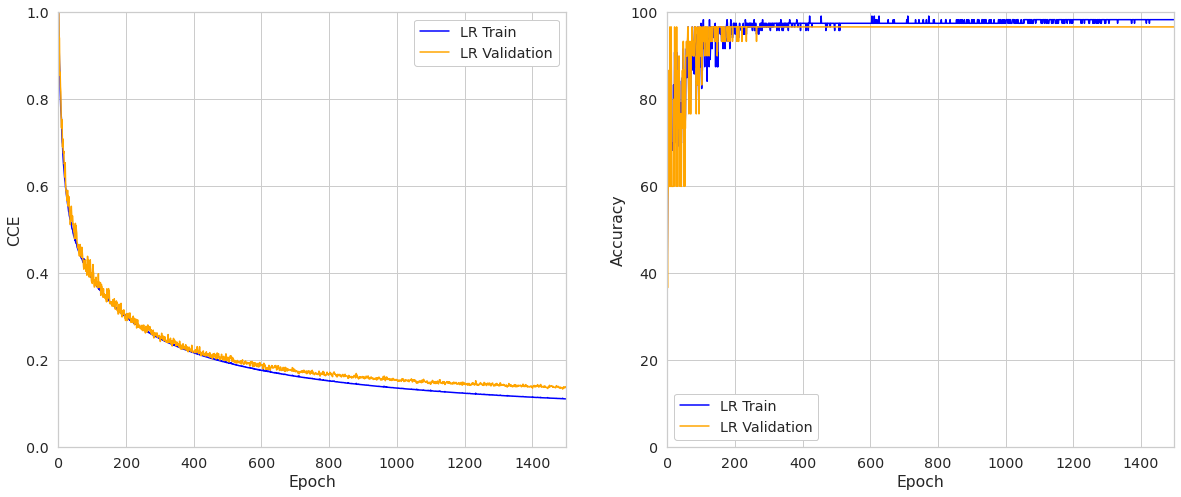

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Финальные метрики

In [ ]:
print("Train accuracy: {:.1f}%".format(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor)[1].item()))
print("Valid accuracy: {:.1f}%".format(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor)[1].item()))

Train accuracy: 98.3%
Valid accuracy: 96.7%


Посмотрим где мы ошибаемся чаще всего - для этого нарисуем матрицу предсказаний и ошибок.

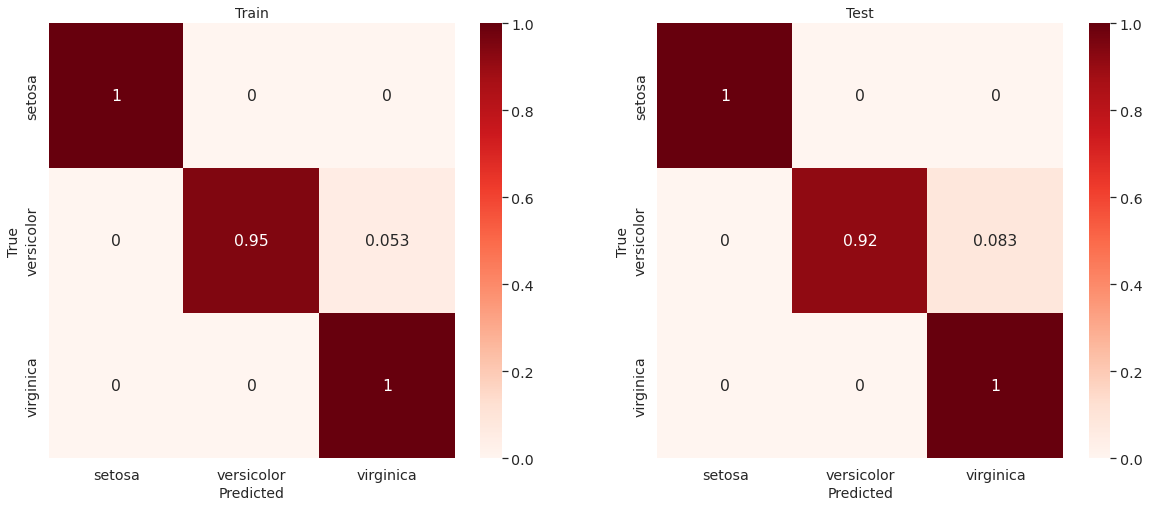

In [ ]:
with torch.no_grad():
    preds_train = model_lr(X_train_tensor)
    preds_valid = model_lr(X_valid_tensor)
    preds_train = np.argmax(preds_train, axis=1)
    preds_valid = np.argmax(preds_valid, axis=1)

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_valid = confusion_matrix(y_valid, preds_valid).astype(np.float32)
cm_valid /= cm_valid.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_valid, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);

###Задание: MLP с 3 скрытыми слоями

Теперь определим более сложную модель с 2 скрытыми слоями и ReLU функцией активации.

![relu image](https://analyticsindiamag.com/wp-content/uploads/2018/01/relu-activation-function-1.png)

Ваша задача - создать нейросеть со следующей архитектурой

* Первый скрытый слой - 16 нейронов
* Функция активации - ReLU
* Второй скрытый слой - 32 нейрона
* Функция активации - ReLU

(Для примера можете посмотреть ноутбук из практической части задания)

In [ ]:

model_mlp_3 = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=n_classes)
)


Сеттинг для обучения такой же как и раньше, за исключением меньшего learning_rate

In [ ]:
opt_mlp_3 = optim.SGD(params=model_mlp_3.parameters(), lr=0.002)

Тренируем модель. 

Ваша задача тут - вписать недостающие шаги в цикле обучения.

Заодно оцените, насколько проще код обучения с использованием `DataLoader`, чем код написанный руками в практической части лекции.



In [ ]:
%%time

epochs_mlp_3 = 1500
history_mlp_3_train = []
history_mlp_3_valid = []

for epoch in tqdm(range(epochs_mlp_3)):
    # формирование батча данных происходит на лету
    for Xb, yb in dataloader_train:
        
        # forward pass: делаем предсказания
        
        pred = model_mlp_3(Xb)
        

        # forward pass: считаем ошибку
       
        loss = loss_func(pred, yb)
        

        # backward pass: считаем градиенты
        
        loss.backward()
        

        # обновление весов
        
        opt_mlp_3.step()
        opt_mlp_3.zero_grad()
        
    
    history_mlp_3_train.append(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor))
    history_mlp_3_valid.append(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor))

history_mlp_3_train = np.array(history_mlp_3_train)
history_mlp_3_valid = np.array(history_mlp_3_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 9.83 s, sys: 171 ms, total: 10 s
Wall time: 10.1 s


Нарисуем как менялась функция ошибки по ходу обучения и сравним это с предыдущей моделью (PyTorch Logistic Regression)

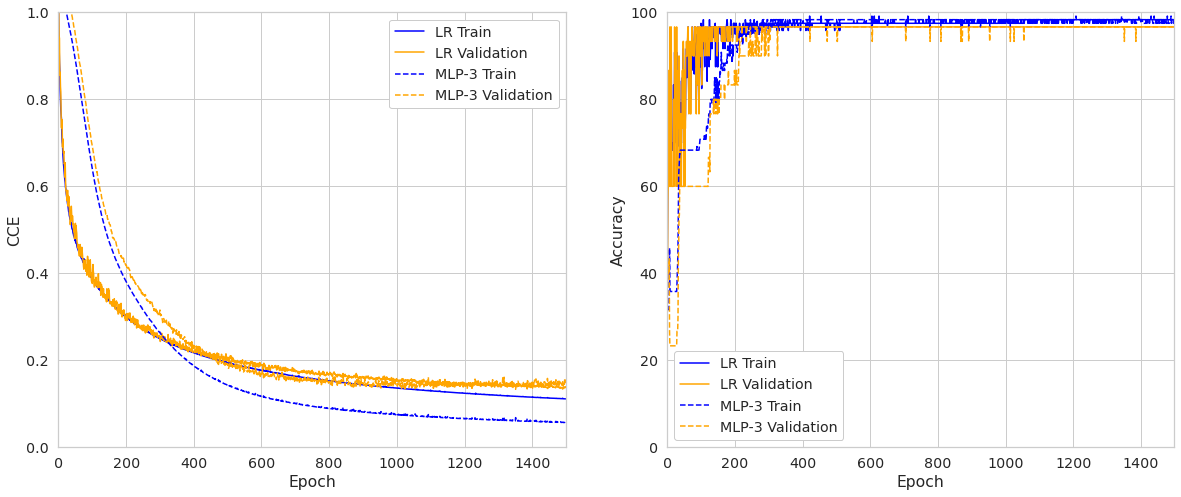

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 0], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 0], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 1], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 1], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Финальные метрики

In [ ]:
print("Train accuracy: {:.1f}%".format(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor)[1].item()))
print("Valid accuracy: {:.1f}%".format(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor)[1].item()))

Train accuracy: 98.3%
Valid accuracy: 96.7%


Посмотрим где мы ошибаемся чаще всего - для этого нарисуем матрицу предсказаний и ошибок.

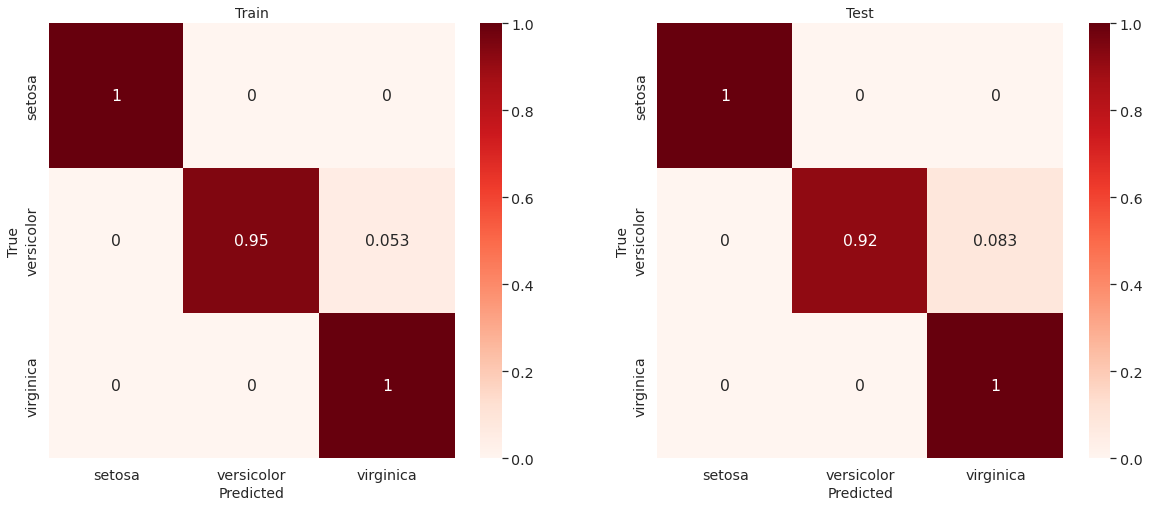

In [ ]:
  with torch.no_grad():
    preds_train = model_lr(X_train_tensor)
    preds_valid = model_lr(X_valid_tensor)
    preds_train = np.argmax(preds_train, axis=1)
    preds_valid = np.argmax(preds_valid, axis=1)

cm_train = confusion_matrix(y_train, preds_train).astype(np.float32)
cm_train /= cm_train.sum(axis=1)[:, np.newaxis]

cm_valid = confusion_matrix(y_valid, preds_valid).astype(np.float32)
cm_valid /= cm_valid.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(20, 8))

plt.subplot(121)
g = sns.heatmap(cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train", fontsize=14)

plt.subplot(122)
g = sns.heatmap(cm_valid, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test", fontsize=14);